In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import tensorflow as tf  # For tf.data
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential

from sklearn.metrics import confusion_matrix,classification_report

from PIL import Image, ImageOps

2023-12-09 09:54:26.040105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## GOAL

For this challenge, the image classification is to be performed on the following 9 classes: Laptop, Monitor, Keyboard, Mouse, Football Ball (Soccer Ball), Bee, Train, Letter M, Letter T.

All source images except for Letter M and Letter T are taken from the [Kaggle ImageNet challenge](https://www.kaggle.com/competitions/imagenet-object-localization-challenge). A full list of ImageNet classes can be found [here](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

For Letter M and Letter T, the source images come from [Kaggle EMNIST](https://www.kaggle.com/datasets/crawford/emnist) dataset.


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
SEED = 11
SKIP_TRAIN = True

# ImageDataGenerator automatically infers the list of classes from the subdirectory names/structure under directory, ordered alphabetically.
TARGET_LABELS = ['bee', 'keyboard', 'laptop', 'letter_M', 'letter_T', 'monitor', 'mouse', 'soccer_ball', 'train']
NUM_TARGETS = len(TARGET_LABELS)

data_dir = './data'


## LOAD AND SPLIT DATASET INTO TRAINING AND VALIDATION SET
(1) Dataset source: [Kaggle ImageNet object localization challenge](https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data) and [Kaggle EMNIST](https://www.kaggle.com/datasets/crawford/emnist). A random 500 images for each class is extracted for the dataset. Take note that the ImageNet data is in image form, while the EMNIST data is consolidated into csv. Therefore, a preprocessing step where the EMNIST data is converted back into images was conducted separately. You may refer to the source code "EMNIST_csv_to_image.ipynb" located in the same folder.

(2) [Source code reference](https://www.kaggle.com/code/archisha26/imagedatagenerator-efficientnet-b0) on how to load images using ImageDataGenerator. Also see [Keras ImageDataGenerator API](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory).

(3) Data augmentation for training set is done in real-time via the ImageDataGenerator object, see [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#args). This helps to:
*   increase the number of training samples on a small dataset.
*   improves model performance to be robust against potentially distorted unseen data.

Note that validation set are only rescaled without any other data augmentation.

(4) 80:20 split of dataset into training and validation set.


In [3]:
# Training generator + Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=[IMAGE_SIZE, IMAGE_SIZE],
    batch_size=BATCH_SIZE,
    seed=SEED,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    subset="training"
)

# Test Generator - Augmentation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=[IMAGE_SIZE, IMAGE_SIZE],
    batch_size=BATCH_SIZE,
    seed=SEED,
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    subset="validation"
)



Found 3600 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


In [4]:
print("Labels for training set:\n {}".format(train_generator.class_indices))

print("Labels for validation set:\n {}".format(val_generator.class_indices))

Labels for training set:
 {'bee': 0, 'keyboard': 1, 'laptop': 2, 'letter_M': 3, 'letter_T': 4, 'monitor': 5, 'mouse': 6, 'soccer_ball': 7, 'train': 8}
Labels for validation set:
 {'bee': 0, 'keyboard': 1, 'laptop': 2, 'letter_M': 3, 'letter_T': 4, 'monitor': 5, 'mouse': 6, 'soccer_ball': 7, 'train': 8}


In [5]:
def plot_hist(model_name, hist):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
    ax1.plot(hist.history["accuracy"], label='training accuracy')
    ax1.plot(hist.history["val_accuracy"], label='validation accuracy')
    ax1.set_title("Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend(loc="upper left")


    ax2.plot(hist.history['loss'], label='training loss')
    ax2.plot(hist.history['val_loss'], label='validation loss')
    ax2.set_title("Loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(loc="upper right")

    fig.tight_layout()
    plt.suptitle("Model {}".format(model_name))
    plt.subplots_adjust(top=0.85)
    plt.show()


## BASIC KERAS MODEL

The dataset is trained on a basic Keras model. See [here](https://www.tensorflow.org/tutorials/images/classification#a_basic_keras_model) for source code reference.

In [6]:
def build_model(num_classes):
    model = Sequential([
      layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.BatchNormalization(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes, activation='softmax', name='pred')
    ], name='basic')

    optimizer = keras.optimizers.Adam(learning_rate=5e-6)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model


2023-12-09 09:54:35.867024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


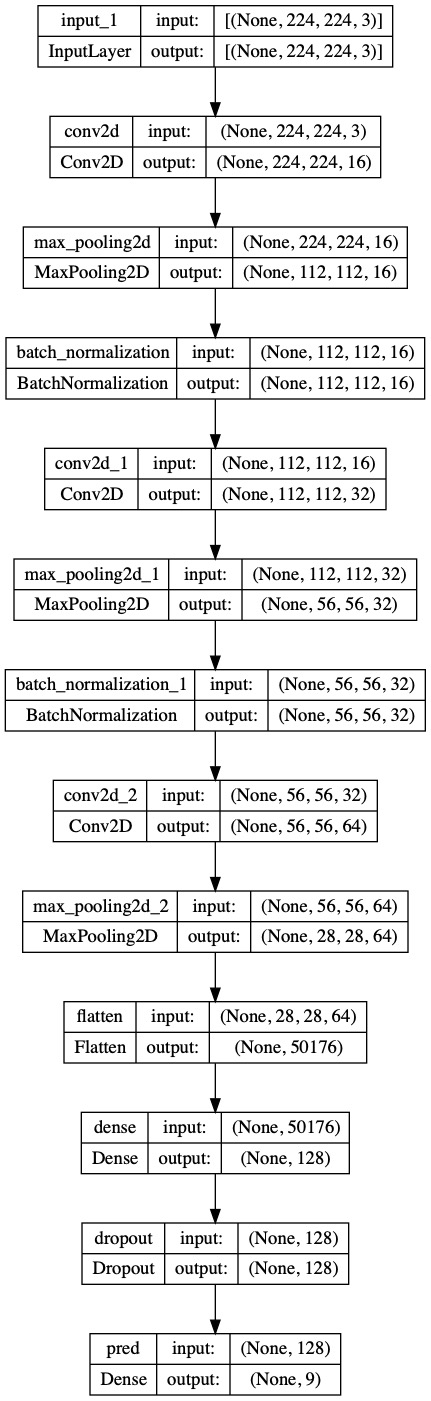

In [7]:
model = build_model(num_classes=NUM_TARGETS)

keras.utils.plot_model(model, to_file='model_architecture.jpg', show_shapes=True)

In [8]:
model.summary()

Model: "basic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                             

## MODEL TRAINING

When SKIP_TRAIN is set to False, the basic model will be trained for 100 Epochs. Otherwise, training will be skipped and the previously saved model will be loaded for the subsequent evaluation and prediction steps. This SKIP_TRAIN is set in place to prevent unwanted model retraining as it requires significant computer resources and is time-consuming.

When SKIP_TRAIN is set to False, the trained model will be saved for subsequent image classification application

See [here](https://machinelearningmastery.com/save-load-keras-deep-learning-models/) for reference. 

In [9]:
if SKIP_TRAIN:
    print("SKIP_TRAIN SET TO {}. Model training will be skipped.".format(SKIP_TRAIN))
    model = keras.models.load_model('CFG-image-classifier-model.h5')
    pass
else:
    EPOCHS = 100  # @param {type: "slider", min:8, max:80}
    
    hist = model.fit(
        train_generator,
        epochs = EPOCHS,
        steps_per_epoch = train_generator.samples//BATCH_SIZE,
        validation_data = val_generator,
        validation_steps = val_generator.samples//BATCH_SIZE,
        workers=8,
        verbose = 1
    )

    model.save("CFG-image-classifier-model.h5")
    print("Saved model to disk")

Epoch 1/100
112/112 [==============================] - 135s 1s/step - loss: 1.9255 - accuracy: 0.2724 - val_loss: 2.2097 - val_accuracy: 0.1328
Epoch 2/100
112/112 [==============================] - 108s 945ms/step - loss: 1.6683 - accuracy: 0.3484 - val_loss: 2.3230 - val_accuracy: 0.1217
Epoch 3/100
112/112 [==============================] - 107s 935ms/step - loss: 1.6017 - accuracy: 0.3722 - val_loss: 2.2162 - val_accuracy: 0.1708
Epoch 4/100
112/112 [==============================] - 107s 941ms/step - loss: 1.5557 - accuracy: 0.3910 - val_loss: 1.7689 - val_accuracy: 0.3214
Epoch 5/100
112/112 [==============================] - 108s 951ms/step - loss: 1.5187 - accuracy: 0.4047 - val_loss: 1.5071 - val_accuracy: 0.4353
Epoch 6/100
112/112 [==============================] - 109s 955ms/step - loss: 1.4831 - accuracy: 0.4260 - val_loss: 1.4610 - val_accuracy: 0.4554
Epoch 7/100
112/112 [==============================] - 111s 970ms/step - loss: 1.4609 - accuracy: 0.4327 - val_loss: 1.47

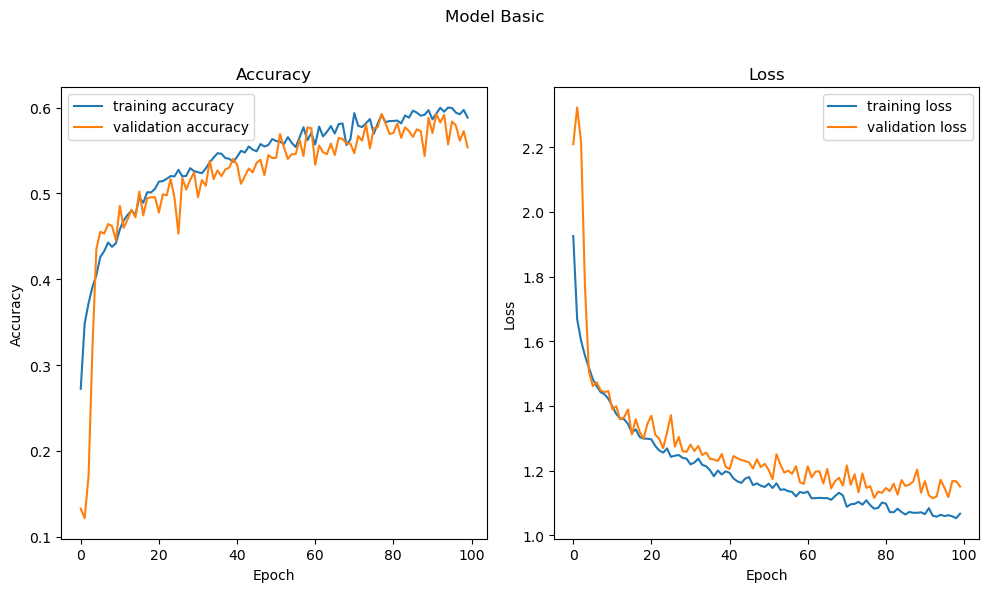

In [10]:
if SKIP_TRAIN:
    print("SKIP_TRAIN SET TO {}. Model training accuracy and loss plots will be skipped.".format(SKIP_TRAIN))
    pass
else: 
    plot_hist("Basic", hist)

## PERFORMANCE EVALUATION

The model's classification performance is evaluated on validation data. As each original prediction is an array of probabilities per class, each prediction is then simplified to a single class by taking only the class with highest likelihood.

The predictions are then used as input for the performance evaluation in confusion matrix and classification report. See [here](https://www.kaggle.com/code/archisha26/imagedatagenerator-efficientnet-b0) for source code reference.

<b>Note</b>: The confusion matrix statistics is defaulted to normalize=True to display numbers between 0 to 1, setting normalize=False will display the actual count of test cases per Actual class-Prediction class pair. 

In [11]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')

Confusion matrix, without normalization


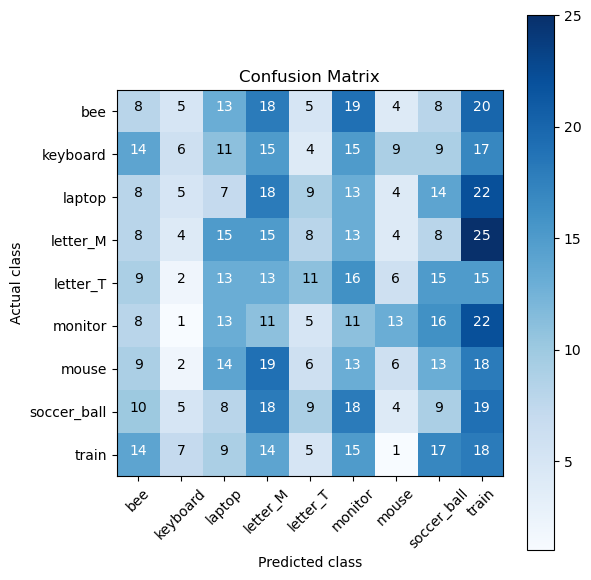

In [12]:
# Evaluate model on validation data
Y_pred = model.predict(val_generator, verbose=0)
y_pred = np.argmax(Y_pred, axis=1)

# display Confusion Matrix
cm = confusion_matrix(val_generator.classes, y_pred)
plot_confusion_matrix(cm, TARGET_LABELS, title='Confusion Matrix', normalize=False)

In [13]:
#Print Classification Report
print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=TARGET_LABELS))

Classification Report
              precision    recall  f1-score   support

         bee       0.09      0.08      0.09       100
    keyboard       0.16      0.06      0.09       100
      laptop       0.07      0.07      0.07       100
    letter_M       0.11      0.15      0.12       100
    letter_T       0.18      0.11      0.14       100
     monitor       0.08      0.11      0.09       100
       mouse       0.12      0.06      0.08       100
 soccer_ball       0.08      0.09      0.09       100
       train       0.10      0.18      0.13       100

    accuracy                           0.10       900
   macro avg       0.11      0.10      0.10       900
weighted avg       0.11      0.10      0.10       900



## TEST PREDICTION

Test prediction on images. [Source code reference](https://blog.streamlit.io/deep-learning-apps-for-image-processing-made-easy-a-step-by-step-guide/).

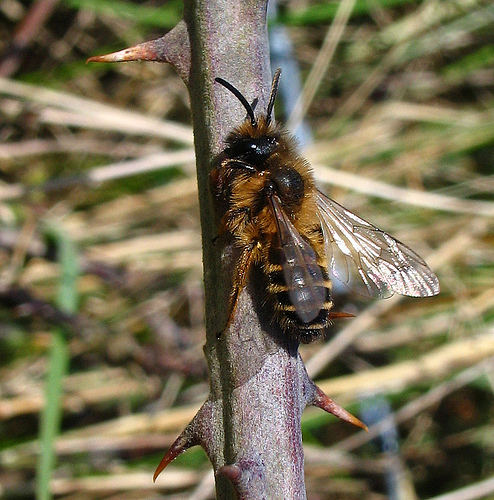

Predicted image class: bee with a probability of 25.36 percent.


Predicted image class: letter_M with a probability of 25.36 percent.


In [14]:
class_names= {0: 'bee', 1:'keyboard', 2:'laptop', 3:'letter_M', 4:'letter_T', 
               5:'monitor', 6:'mouse', 7:'soccer_ball', 8:'train'}

image_data1 = Image.open('./data/bee/n02206856_18.JPEG')
image_data2 = Image.open('./data/letter_M/14.JPG')

def predict_image(image_data):
    size = (IMAGE_SIZE, IMAGE_SIZE)    
    image = ImageOps.fit(image_data, size, Image.Resampling.LANCZOS)
    img = np.asarray(image)
    img_reshape = img[np.newaxis,...]
    display(image_data)
    prediction = model.predict(img_reshape, verbose=0)
    score = tf.nn.softmax(prediction[0])
    
    output = "Predicted image class: {} with a probability of {:.2f} percent."
    output = output.format(class_names[np.argmax(score)], 100 * np.max(score))
    return output

print(predict_image(image_data1))
print(predict_image(image_data2))